In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_05/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment)+ '_3')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		1.47276% 	7.24297% 	0.04888		0.0309		0.0		1.0	
(1024,256) 	95.4% 		0.5283% 	6.43326% 	0.82382		0.8044		5e-05		0.9625	
(1024,1024) 	3.04% 		1.91647% 	2.30844% 	0.02452		0.0034		0.0		0.30343	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.78142 1.00000 0.21858 	(213910, 0.9037879560274013) 0.86703 0.90379 0.03676 	(688427, 0.938751472320377) 0.02720 0.93875 0.91155 	
(32635, 1.0) 0.99950 1.00000 0.00050 	(212974, 0.8941978001127759) 0.86036 0.89420 0.03384 	(4240, 0.9623085983510011) 0.25113 0.96231 0.71118 	
(2436, 1.0) 0.87171 1.00000 0.12829 	(44828, 0.8401417658060423) 0.84893 0.84014 0.00878 	(694929, 0.9799764428739693) 0.01303 0.97998 0.96695 	
(55808, 1.0) 0.68042 1.00000 0.31958 	(232148, 0.8783613613364569) 0.87199 0.87836 0.00637 	(600540, 0.5747938751472321) 0.02626 0.57479 0.54854 	
(44159, 1.0) 0.76138 1.00000 0.23862 	(106790, 0.8420843224691953) 0.85843 0.84208 0.01635 	(226406, 0.8680800942285042) 0.08773 0.86808 0.78035 	
(25344, 1.0) 0.97215 1.00000 0.02785 	(155900, 0.8219974944514251) 0.84057 0.82200 0.01857 	(122896, 0.99528857

(59523, 1.0) 0.35083 1.00000 0.64917 	(129155, 0.7999979872765527) 0.85807 0.80000 0.05807 	(183631, 0.06478209658421678) 0.07104 0.06478 0.00625 	
(57344, 1.0) 0.79050 1.00000 0.20950 	(235128, 0.8727188163808299) 0.87357 0.87272 0.00085 	(579985, 0.8833922261484101) 0.04860 0.88339 0.83479 	
(58378, 1.0) 0.01934 1.00000 0.98066 	(87579, 0.8313707011729192) 0.85807 0.83137 0.02670 	(525404, 0.9411071849234394) 0.06264 0.94111 0.87847 	
(17152, 1.0) 1.00000 1.00000 0.00000 	(71512, 0.9671947492957347) 0.86355 0.96719 0.10365 	(571684, 0.8881036513545347) 0.04075 0.88810 0.84735 	
(5505, 1.0) 0.53355 1.00000 0.46645 	(136388, 0.8390310859768031) 0.85374 0.83903 0.01471 	(700469, 0.9057714958775029) 0.05073 0.90577 0.85504 	
(1727, 1.0) 0.01286 1.00000 0.98714 	(141587, 0.9235756318547628) 0.86749 0.92358 0.05608 	(208581, 0.08362779740871625) 0.00477 0.08363 0.07886 	
(30605, 1.0) 0.99869 1.00000 0.00131 	(26153, 0.7452398860506029) 0.77024 0.74524 0.02500 	(157174, 1.0) 0.05638 1.00000

(17299, 1.0) 0.60608 1.00000 0.39392 	(260565, 0.8569984305801116) 0.83121 0.85700 0.02579 	(307940, 0.9081272084805654) 0.02394 0.90813 0.88419 	
(3583, 1.0) 0.87697 1.00000 0.12303 	(101553, 0.8154719704976244) 0.84642 0.81547 0.03095 	(78981, 0.6383981154299176) 0.22292 0.63840 0.41548 	
(101632, 1.0) 0.97779 1.00000 0.02221 	(109056, 0.8128818385580182) 0.84997 0.81288 0.03709 	(37897, 0.6395759717314488) 0.28036 0.63958 0.35922 	
(2813, 1.0) 0.65437 1.00000 0.34563 	(106336, 0.837155641146507) 0.86019 0.83716 0.02303 	(70064, 1.0) 0.13425 1.00000 0.86575 	
(57494, 1.0) 0.01850 1.00000 0.98150 	(127674, 0.8341266731748087) 0.84798 0.83413 0.01386 	(219145, 0.43934040047114253) 0.28145 0.43934 0.15790 	
(52733, 1.0) 1.00000 1.00000 0.00000 	(215375, 0.915671669561574) 0.87002 0.91567 0.04566 	(550003, 0.8881036513545347) 0.07223 0.88810 0.81587 	
(13193, 1.0) 0.29954 1.00000 0.70046 	(220183, 0.9147932322091735) 0.87900 0.91479 0.03579 	(14454, 0.9681978798586572) 0.28826 0.96820 0.

(71300, 1.0) 0.21492 1.00000 0.78508 	(161769, 0.8889750997549195) 0.85622 0.88898 0.03275 	(479439, 0.9316843345111897) 0.04581 0.93168 0.88588 	
(67713, 1.0) 0.22209 1.00000 0.77791 	(114369, 0.948370456114582) 0.90327 0.94837 0.04510 	(175119, 0.9976442873969376) 0.27077 0.99764 0.72687 	
(23831, 1.0) 0.41596 1.00000 0.58404 	(256541, 0.8888296102974736) 0.85081 0.88883 0.03802 	(203825, 0.9116607773851589) 0.19365 0.91166 0.71801 	
(9752, 1.0) 0.55212 1.00000 0.44788 	(17541, 0.7695029790757576) 0.75862 0.76950 0.01088 	(26981, 0.8362779740871614) 0.09083 0.83628 0.74545 	
(28683, 1.0) 0.33485 1.00000 0.66515 	(92349, 0.8329746862734568) 0.85577 0.83297 0.02279 	(391220, 0.7561837455830389) 0.07928 0.75618 0.67690 	
(52513, 1.0) 0.75922 1.00000 0.24078 	(244001, 0.874901771122834) 0.85724 0.87490 0.01766 	(45085, 0.9352179034157833) 0.19795 0.93522 0.73727 	
(21422, 1.0) 0.03302 1.00000 0.96698 	(230762, 0.8672566789741019) 0.86759 0.86726 0.00033 	(116752, 0.9363957597173145) 0.26

(57364, 1.0) 0.09850 1.00000 0.90150 	(77755, 0.9021742777391745) 0.85880 0.90217 0.04337 	(600437, 0.5677267373380448) 0.02562 0.56773 0.54211 	
(36740, 1.0) 0.54023 1.00000 0.45977 	(81048, 0.89729927575345) 0.86220 0.89730 0.03510 	(85089, 0.994110718492344) 0.17394 0.99411 0.82017 	
(24318, 1.0) 0.99870 1.00000 0.00130 	(250663, 0.909449404481014) 0.87418 0.90945 0.03527 	(111843, 0.8928150765606597) 0.09545 0.89282 0.79737 	
(30080, 1.0) 0.99995 1.00000 0.00005 	(154043, 0.8384354635406963) 0.85890 0.83844 0.02046 	(97821, 0.8928150765606597) 0.03990 0.89282 0.85291 	
(11520, 1.0) 0.99987 1.00000 0.00013 	(136053, 0.8494856414684885) 0.85207 0.84949 0.00259 	(1047237, 0.040047114252061256) 0.01000 0.04005 0.03005 	
(16795, 1.0) 0.74106 1.00000 0.25894 	(84320, 0.8398393595508763) 0.86070 0.83984 0.02086 	(131187, 0.9305064782096585) 0.19365 0.93051 0.73685 	
(32894, 1.0) 0.99814 1.00000 0.00186 	(237613, 0.8682838213636963) 0.87137 0.86828 0.00309 	(225447, 0.9976442873969376) 0.0

(54915, 1.0) 0.57842 1.00000 0.42158 	(85361, 0.8621324479438804) 0.89079 0.86213 0.02866 	(280646, 0.9363957597173145) 0.08899 0.93640 0.84741 	
(17934, 1.0) 0.91287 1.00000 0.08713 	(260400, 0.8151508578368154) 0.81146 0.81515 0.00370 	(120476, 0.8869257950530036) 0.01271 0.88693 0.87422 	
(19475, 1.0) 0.56982 1.00000 0.43018 	(195711, 0.8518479630503047) 0.86986 0.85185 0.01801 	(5786, 0.8398115429917551) 0.04072 0.83981 0.79910 	
(69413, 1.0) 0.02646 1.00000 0.97354 	(94565, 0.9028472883172113) 0.84461 0.90285 0.05824 	(367847, 0.8716136631330978) 0.06973 0.87161 0.80188 	
(17919, 1.0) 0.99792 1.00000 0.00208 	(250174, 0.855742306732544) 0.86223 0.85574 0.00649 	(633163, 0.7385159010600707) 0.02994 0.73852 0.70858 	
(49916, 1.0) 0.94464 1.00000 0.05536 	(106722, 0.869132617409218) 0.84707 0.86913 0.02206 	(506011, 0.9340400471142521) 0.07140 0.93404 0.86264 	
(49066, 1.0) 0.74749 1.00000 0.25251 	(146392, 0.9133931105713333) 0.87422 0.91339 0.03917 	(164138, 0.9988221436984688) 0.0

(5899, 1.0) 0.18121 1.00000 0.81879 	(16295, 0.7647971904350622) 0.72251 0.76480 0.04229 	(55044, 0.41107184923439344) 0.02268 0.41107 0.38839 	
(42117, 1.0) 0.89979 1.00000 0.10021 	(107637, 0.8970799608454415) 0.86088 0.89708 0.03620 	(73896, 0.7797408716136632) 0.16876 0.77974 0.61098 	
(31100, 1.0) 0.99612 1.00000 0.00388 	(252123, 0.8832088031638589) 0.87397 0.88321 0.00924 	(153754, 0.5206124852767963) 0.13020 0.52061 0.39041 	
(34304, 1.0) 0.97903 1.00000 0.02097 	(164420, 0.8417064083459637) 0.85625 0.84171 0.01455 	(433456, 0.657243816254417) 0.05854 0.65724 0.59870 	
(2427, 1.0) 0.42173 1.00000 0.57827 	(146162, 0.9318169480565922) 0.86161 0.93182 0.07021 	(181593, 0.8904593639575972) 0.07850 0.89046 0.81196 	
(23844, 1.0) 0.40618 1.00000 0.59382 	(45733, 0.9273769224735481) 0.84946 0.92738 0.07792 	(218322, 0.8044758539458187) 0.05902 0.80448 0.74545 	
(58764, 1.0) 0.19542 1.00000 0.80458 	(243754, 0.878781806042009) 0.86441 0.87878 0.01437 	(31807, 0.7997644287396938) 0.248

(73220, 1.0) 0.99995 1.00000 0.00005 	(33413, 0.778189160411582) 0.78843 0.77819 0.01024 	(237823, 0.8998822143698468) 0.06296 0.89988 0.83692 	
(35865, 1.0) 0.15256 1.00000 0.84744 	(41204, 0.7843345203281347) 0.83025 0.78433 0.04591 	(155916, 0.8881036513545347) 0.09288 0.88810 0.79522 	
(45826, 1.0) 0.50872 1.00000 0.49128 	(126178, 0.9023159420934498) 0.86419 0.90232 0.03813 	(209520, 0.7997644287396938) 0.03572 0.79976 0.76404 	
(115841, 1.0) 1.00000 1.00000 0.00000 	(70072, 0.8708748643846019) 0.86252 0.87087 0.00835 	(331887, 0.19316843345111895) 0.05985 0.19317 0.13332 	
(0, 1.0) 0.61723 1.00000 0.38277 	(99679, 0.885449289110872) 0.86062 0.88545 0.02482 	(256238, 0.7738515901060071) 0.08103 0.77385 0.69282 	
(64139, 1.0) 0.99748 1.00000 0.00252 	(160931, 0.8333184693688391) 0.85604 0.83332 0.02272 	(203055, 0.5406360424028269) 0.09957 0.54064 0.44107 	
(91781, 1.0) 0.99989 1.00000 0.00011 	(13263, 0.8155766184078163) 0.77185 0.81558 0.04373 	(451638, 1.0) 0.07430 1.00000 0.925

(30849, 1.0) 0.99913 1.00000 0.00087 	(78953, 0.8496581148669601) 0.86239 0.84966 0.01273 	(305867, 0.9316843345111897) 0.02437 0.93168 0.90731 	
(20628, 1.0) 0.15205 1.00000 0.84795 	(127105, 0.8540905750718667) 0.85333 0.85409 0.00076 	(115737, 0.9658421672555949) 0.21776 0.96584 0.74808 	
(3328, 1.0) 0.96859 1.00000 0.03141 	(236741, 0.8869982168472444) 0.87263 0.88700 0.01437 	(4216, 0.9163722025912839) 0.26216 0.91637 0.65421 	
(113409, 1.0) 1.00000 1.00000 0.00000 	(192311, 0.8926247991216609) 0.86751 0.89262 0.02511 	(345325, 0.8916372202591284) 0.05891 0.89164 0.83273 	
(95493, 1.0) 0.19367 1.00000 0.80633 	(106074, 0.8490803274896342) 0.86151 0.84908 0.01243 	(288840, 0.9599528857479388) 0.10228 0.95995 0.85767 	
(36482, 1.0) 0.17737 1.00000 0.82263 	(221737, 0.8550796353812937) 0.88396 0.85508 0.02888 	(535554, 0.9976442873969376) 0.06360 0.99764 0.93404 	
(21757, 1.0) 0.93311 1.00000 0.06689 	(252472, 0.8897609083883393) 0.86315 0.88976 0.02661 	(636086, 0.96113074204947) 0.

(83204, 1.0) 0.99999 1.00000 0.00001 	(158730, 0.898673972958837) 0.88167 0.89867 0.01700 	(110617, 0.36395759717314485) 0.21549 0.36396 0.14847 	
(37135, 1.0) 0.08531 1.00000 0.91469 	(37354, 0.8564350625269722) 0.84856 0.85644 0.00787 	(262379, 0.9740871613663132) 0.07252 0.97409 0.90157 	
(56576, 1.0) 0.78692 1.00000 0.21308 	(63691, 0.8264761295751925) 0.85473 0.82648 0.02825 	(182510, 0.9623085983510011) 0.08739 0.96231 0.87492 	
(11535, 1.0) 0.11731 1.00000 0.88269 	(104566, 0.828796432830408) 0.84452 0.82880 0.01572 	(748775, 0.9352179034157833) 0.02254 0.93522 0.91268 	
(16901, 1.0) 0.96840 1.00000 0.03160 	(20866, 0.7798445033965178) 0.78330 0.77984 0.00346 	(321743, 0.9988221436984688) 0.06431 0.99882 0.93451 	
(4733, 1.0) 0.49107 1.00000 0.50893 	(205697, 0.8540255774062032) 0.86010 0.85403 0.00608 	(66629, 0.856301531213192) 0.22959 0.85630 0.62672 	
(88835, 1.0) 0.99963 1.00000 0.00037 	(198300, 0.8400371164525748) 0.85326 0.84004 0.01323 	(343828, 0.5559481743227327) 0.01

(15235, 1.0) 0.77636 1.00000 0.22364 	(191652, 0.868715650240178) 0.86704 0.86872 0.00167 	(103819, 0.9469964664310954) 0.06201 0.94700 0.88499 	
(15506, 1.0) 0.93425 1.00000 0.06575 	(151641, 0.8253741727779265) 0.83934 0.82537 0.01396 	(536622, 0.9599528857479388) 0.05329 0.95995 0.90666 	
(13181, 1.0) 0.97166 1.00000 0.02834 	(218687, 0.9106961520087443) 0.86528 0.91070 0.04542 	(396334, 0.9528857479387515) 0.09306 0.95289 0.85983 	
(6655, 1.0) 0.94907 1.00000 0.05093 	(14691, 0.8487331979469075) 0.59388 0.84873 0.25485 	(213272, 0.92226148409894) 0.05754 0.92226 0.86472 	
(8461, 1.0) 0.31195 1.00000 0.68805 	(46085, 0.8101512085909478) 0.81862 0.81015 0.00847 	(398977, 0.9199057714958776) 0.02261 0.91991 0.89730 	
(23297, 1.0) 0.26106 1.00000 0.73894 	(246423, 0.8630512310170013) 0.86921 0.86305 0.00616 	(559461, 0.30388692579505305) 0.03399 0.30389 0.26989 	
(16509, 1.0) 0.97334 1.00000 0.02666 	(121595, 0.9135095814918005) 0.86428 0.91351 0.04923 	(101579, 0.9269729093050648) 0.0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
6.4062064e-34
1.0
5.393537e-05
0.9624966
1.18656e-08
0.30342638


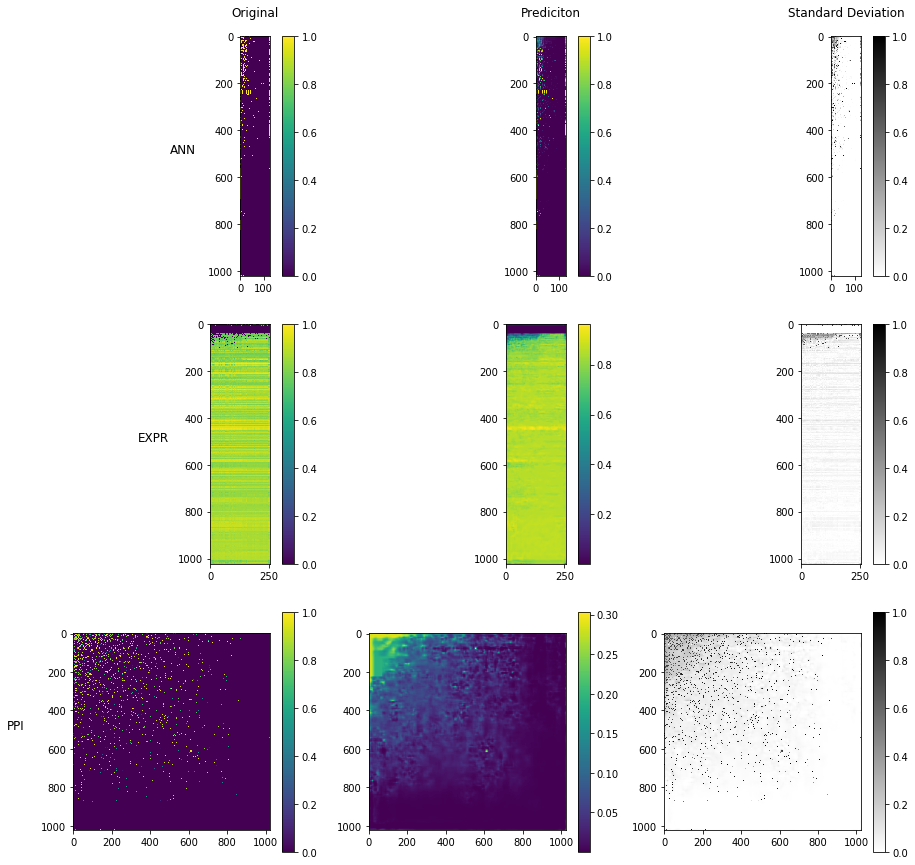

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_05/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;
    
    
cols = ['{}'.format(col) for col in ['Original', 'Prediciton', 'Standard Deviation']]
rows = ['{}'.format(row) for row in ['ANN', 'EXPR', 'PPI']]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    
for i in range(len(model.org_data)):
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[i][0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))
    ax.set_ylabel(rows[i], labelpad=25, rotation=0, size='large')
    if i == 0:
        ax.set_title(cols[0], pad=20)

    ax = axes[i][1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))
    if i == 0:
        ax.set_title(cols[1], pad=20)

    ax = axes[i][2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    if i == 0:
        ax.set_title(cols[2], pad=20)
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[i][0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[i][1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[i][2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict_all.png')

plt.show()


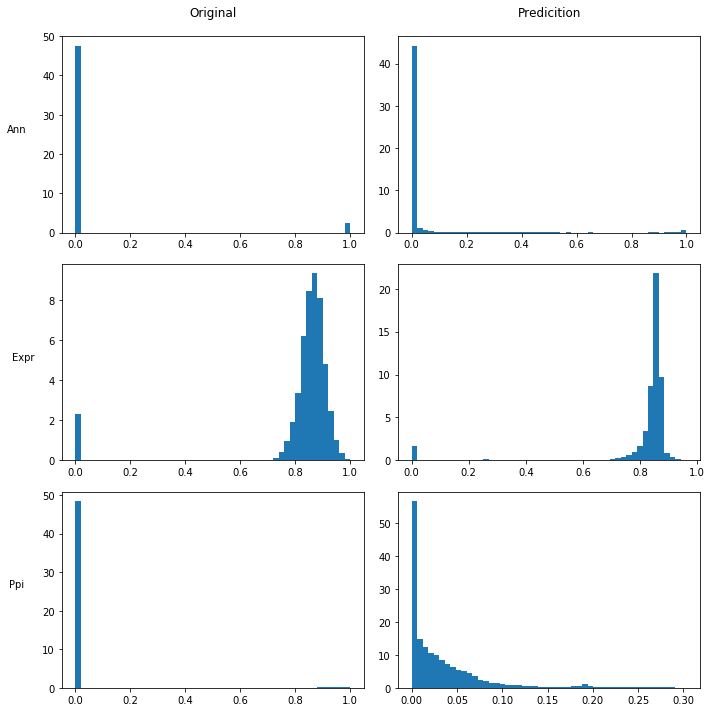

In [6]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'Ppi']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, org_data in enumerate(model.org_data):
    org_data = org_data.flatten()
    pred_data = model.predict_data[i].flatten()
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=1)

    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=1)
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'data_distribution.png')
plt.show()

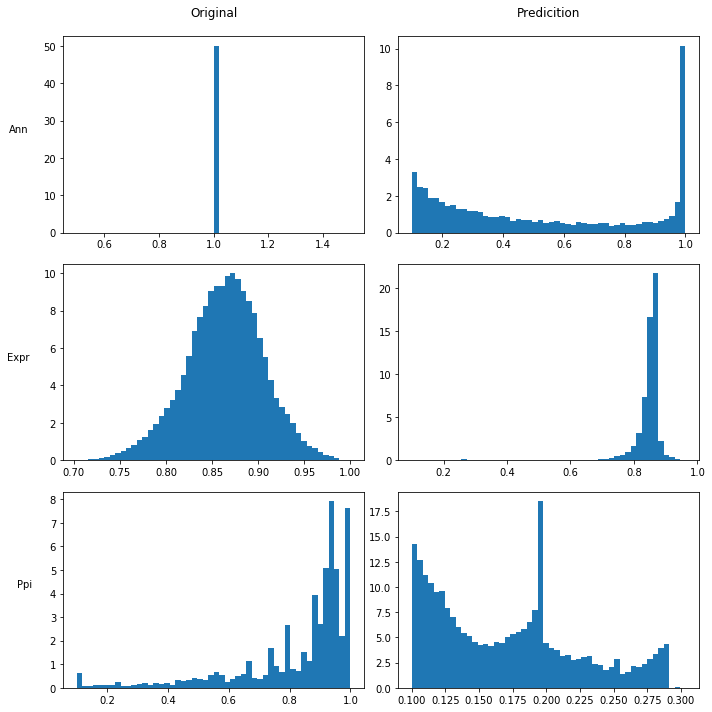

In [7]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'Ppi']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, org_data in enumerate(model.org_data):
    
    org_data = org_data.flatten()
    pred_data = model.predict_data[i].flatten()
    org_data = org_data[org_data > .1]
    pred_data = pred_data[pred_data > .1]
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=1)

    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=1)
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'data_distribution_zoom_01.png')
plt.show()

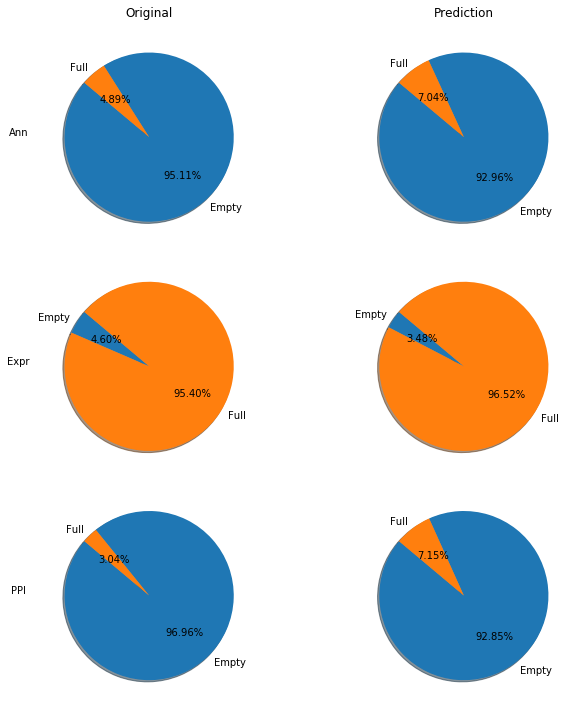

In [8]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    
    org_data_zeros = org_data[org_data == 0]
    org_data_nonzeros = org_data[org_data > 0]
    
    pred_data_zeros = pred_data[pred_data < 0.1]
    pred_data_nonzeros = pred_data[pred_data >= 0.1]
    
    ax = axes[i][0]
    ax.pie([len(org_data_zeros), len(org_data_nonzeros)], labels=labels, autopct='%1.2f%%', shadow=True, startangle=140)
    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    if i == 0:
        ax.set_title(cols[0],pad=15)
    
    
    ax = axes[i][1]
    ax.pie([len(pred_data_zeros), len(pred_data_nonzeros)], labels=labels, autopct='%1.2f%%', shadow=True, startangle=140)
    
    if i == 0:
        ax.set_title(cols[1],pad=15)
        
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'pie_chart_zoom_01.png')
plt.show()

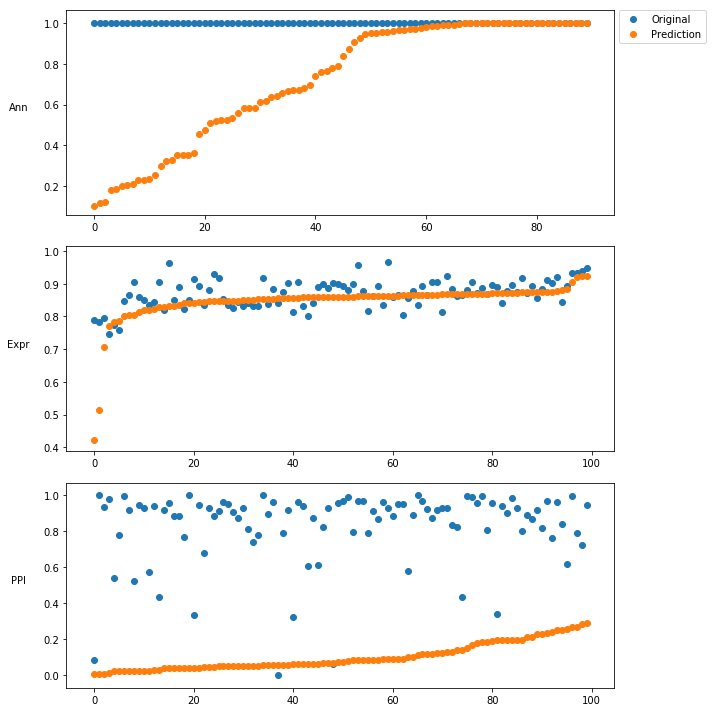

In [9]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[100:200])):
        if i == 0:
            if predict_data[j][1] > 0.1:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.1:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    ax = axes[i]
    data = sorted(data, key=lambda l:l[3])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
        
    data = np.asarray(data)
    ax.scatter(data[:,0], data[:,1], label='Original')
    ax.scatter(data[:,2], data[:,3], label='Prediction')
    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1, 1.025))
    
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'test_cells_org_vs_prediction.png')
plt.show()

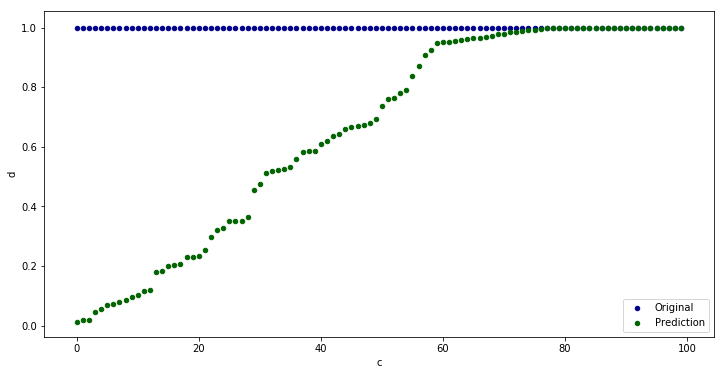

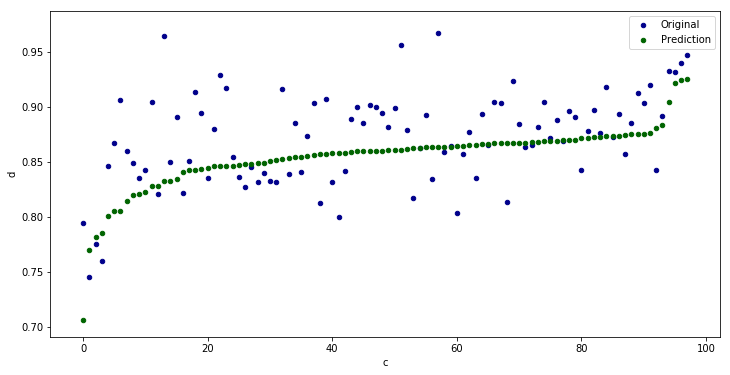

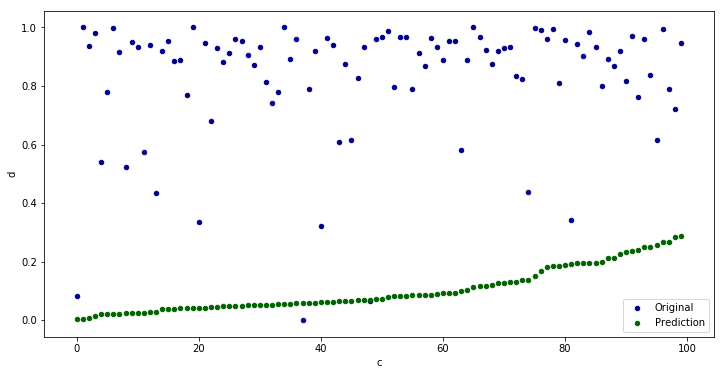

In [90]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[400:500])):
        if i == 0:
            if predict_data[j][1] > 0:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    data = sorted(data, key=lambda l:l[3])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
    
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

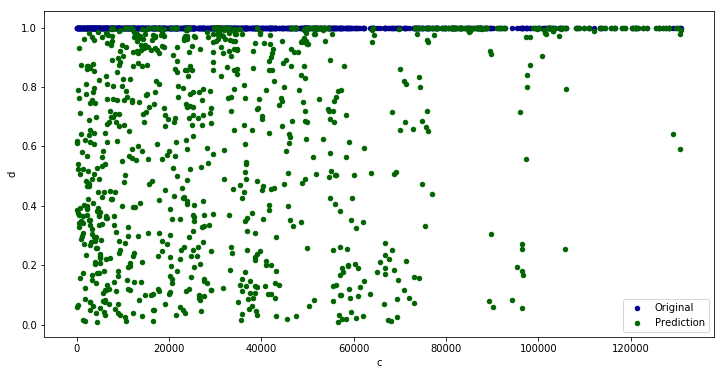

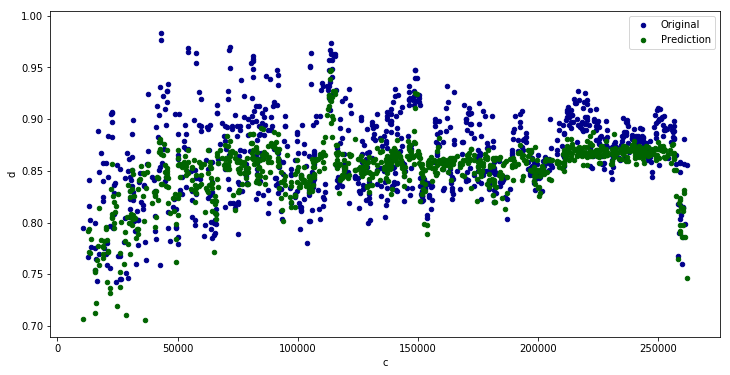

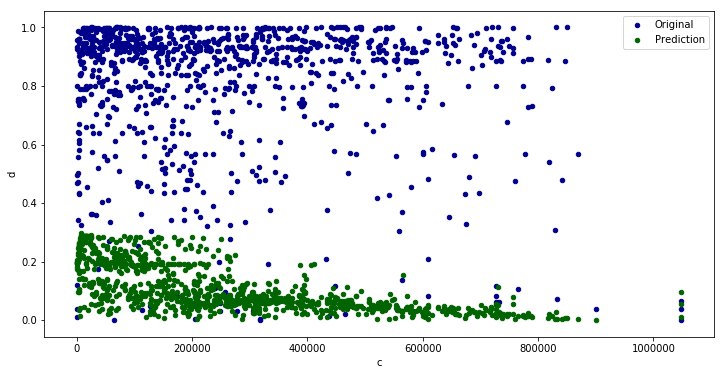

In [91]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    
            
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

In [10]:
from builtins import enumerate

print(__doc__)

# from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

import sys
#sys.path.append('/mag/scripts')
sys.path.append('/home/lpodgorsek/mag/scripts')
import utilityFunctions as uf
import base2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data

def remove_cells(data, cells):
    row, col = data.shape
    data = data.flatten()
    for cell in cells:
        data[cell[0]] = 0
    
    return data.reshape(row, col)


test_cells_ann = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
test_cells_expr = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_expr.npz')
test_cells_ppi = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ppi.npz')

dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

dicty[gene][go_term][0].data = base2.resize_rows_and_columns_data(dicty[gene][go_term][0].data, 2)
dicty[gene][exp_cond][0].data = base2.resize_rows_and_columns_data(dicty[gene][exp_cond][0].data, 2)
dicty[gene][gene][0].data = base2.resize_rows_and_columns_data(dicty[gene][gene][0].data, 2)

dicty[gene][go_term][0].data = uf.normalization(dicty[gene][go_term][0].data)
dicty[gene][exp_cond][0].data = uf.normalization(dicty[gene][exp_cond][0].data)
dicty[gene][gene][0].data = uf.normalization(dicty[gene][gene][0].data)

dicty[gene][go_term][0].data = uf.order_by_clustering(dicty[gene][go_term][0].data, 'single')
dicty[gene][exp_cond][0].data = uf.order_by_clustering(dicty[gene][exp_cond][0].data, 'single')
dicty[gene][gene][0].data = uf.order_by_clustering(dicty[gene][gene][0].data, 'single')

dicty[gene][go_term][0].data = remove_cells(dicty[gene][go_term][0].data, test_cells_ann)
dicty[gene][exp_cond][0].data = remove_cells(dicty[gene][exp_cond][0].data, test_cells_expr)
dicty[gene][gene][0].data = remove_cells(dicty[gene][gene][0].data, test_cells_ppi)


n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]

kfold = KFold(n_splits=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)


org_data_DFMF = dicty[gene][go_term][0].data
predict_DFMF = np.empty((0, 128))

data_idx = [x for x in range(n_genes)]
for i, (train_idx, test_idx) in enumerate(kfold.split(data_idx)):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask
    

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)
    predict_DFMF = np.r_[predict_DFMF, pred_ann]

print("MSE: %5.4f" % np.mean(fold_mse))

test_cells = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
predict_cells = []
org_cells = []
# test_cells = test_cells[:10]

avg_diff = 0
predict_data = predict_DFMF.flatten()
print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
print("---------------------------------------------------------------------------------------")
for i in range(len(test_cells)):
    org_val = test_cells[i][1]
    predict_val = predict_data[test_cells[i][0]]
    diff_abs = np.abs(org_val - predict_val)
#     print(str(test_cells[i]) + ' ' + format(predict_val, '.5f') + ' ' + format(org_val, '.5f') + ' ' + format(diff_abs, '.5f') )
    
    avg_diff += diff_abs
    org_cells.append([test_cells[i][0], test_cells[i][1]])
    predict_cells.append([test_cells[i][0], predict_val])
    

# print()
# print("---------------------------------------------------------------------------------------")

val = avg_diff*100/len(test_cells)
print("\t\t" + format(val, '.5f') + "%", end="\t")
print()

Automatically created module for IPython interactive environment
MSE: 0.0300
Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
		75.74022%	


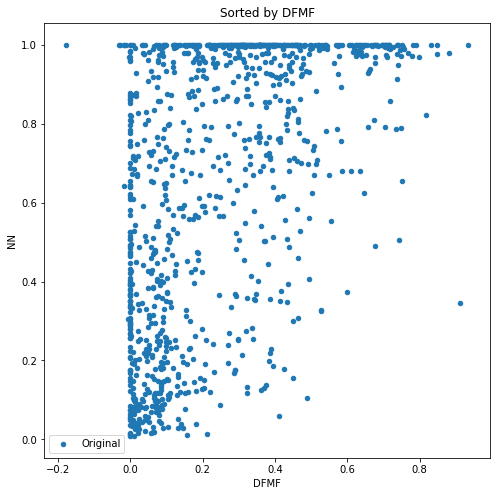

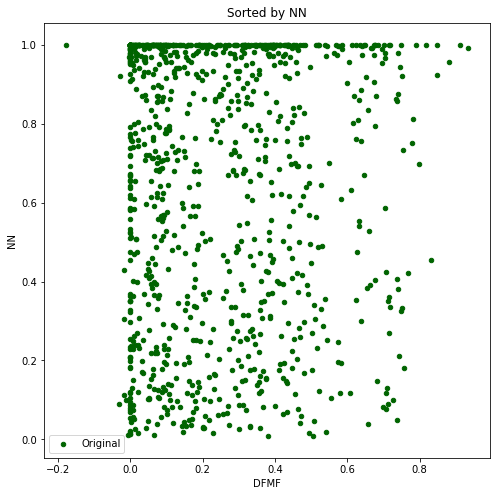

In [116]:
org_data = model.saved_cells_for_test[0]
predict_data = model.predict_saved_cells_for_test[0]
data = []

# podatki urejenei po index
predict_data = sorted(predict_data, key=lambda l:l[0])
predict_cells = sorted(predict_cells, key=lambda l:l[0])

for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[0])
# for j in range(len(data)):
#     data[j][1] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', label='Original', ax=ax);
ax.title.set_text('Sorted by DFMF')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')

org_data = model.saved_cells_for_test[0]
predict_data = model.predict_saved_cells_for_test[0]
data = []
for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[1])
# for j in range(len(data)):
#     data[j][0] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', color='DarkGreen', label='Original', ax=ax);
ax.title.set_text('Sorted by NN')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')

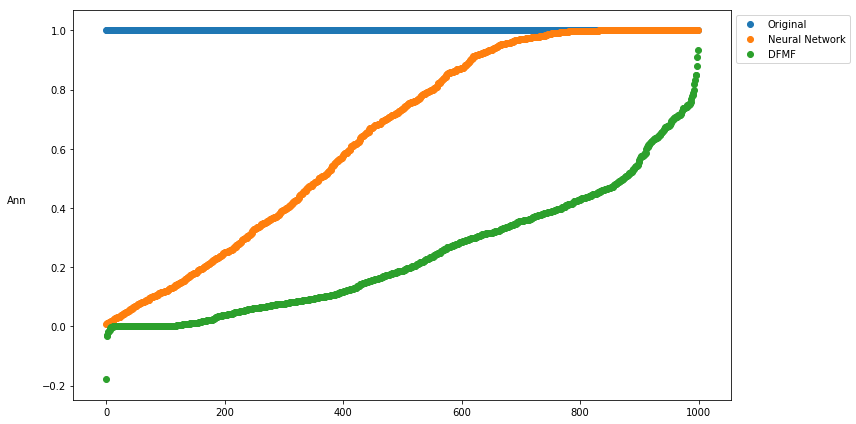

In [11]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

for i in range(1):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    dfmf_predict = []
    for j in range(len(org_data)):
#         if i == 0:
#             if predict_data[j][1] > 0.1:
        data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        dfmf_predict.append([predict_cells[j][0], predict_cells[j][1]])

            
#     ax = axes[i]
    data = sorted(data, key=lambda l:l[3])
    dfmf_predict = sorted(dfmf_predict, key=lambda l:l[1])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
        dfmf_predict[j][0] = j
        
    data = np.asarray(data)
    dfmf_predict = np.asarray(dfmf_predict)
    ax.scatter(data[:,0], data[:,1], label='Original')
    ax.scatter(data[:,2], data[:,3], label='Neural Network')
    ax.scatter(dfmf_predict[:,0], dfmf_predict[:,1], label='DFMF')
    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1, 1.0))
    
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'test_cells_org_vs_nn_vs_dfmf.png')
plt.show()

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)


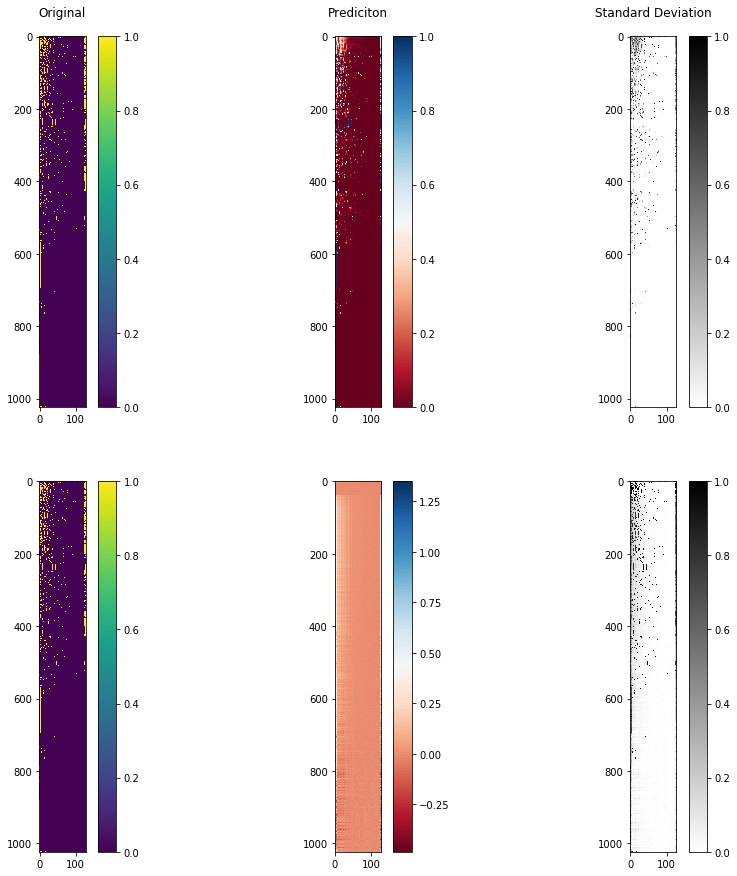

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_05/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
# color_pack2 = 'viridis'
color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;
    
    
cols = ['{}'.format(col) for col in ['Original', 'Prediciton', 'Standard Deviation']]
rows = ['{}'.format(row) for row in ['ANN', 'EXPR', 'PPI']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
    
for i in range(2):
    _, row, col, _ = model.org_data[0].shape
    org_data = model.org_data[0].reshape((row, col))
    predict = model.predict_data[0].reshape((row, col))

    if i == 1:
        predict = predict_DFMF


    ax = axes[i][0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))
#         ax.set_ylabel(rows[i], labelpad=25, rotation=0, size='large')
    if i == 0: 
        ax.set_title(cols[0], pad=20)

    ax = axes[i][1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))
    if i == 0: 
        ax.set_title(cols[1], pad=20)

    ax = axes[i][2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    if i == 0: 
        ax.set_title(cols[2], pad=20)
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[i][0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[i][1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[i][2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'ann_org_vs_nn_vs_dfmf.png')
plt.show()


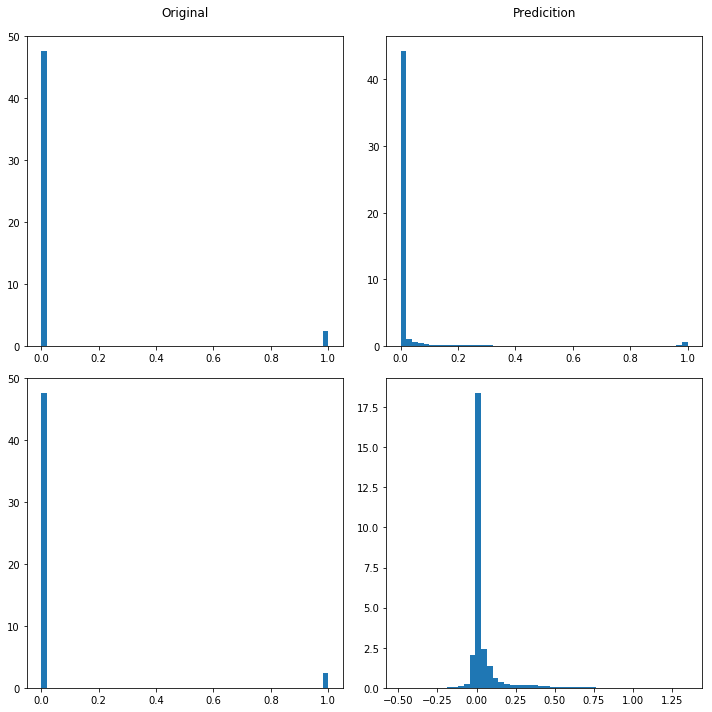

In [13]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'Ppi']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    if i == 1:
        pred_data = predict_DFMF.flatten()
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=1)

#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=1)
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'ann_data_distribution_nn_vs_dfmf.png')
plt.show()

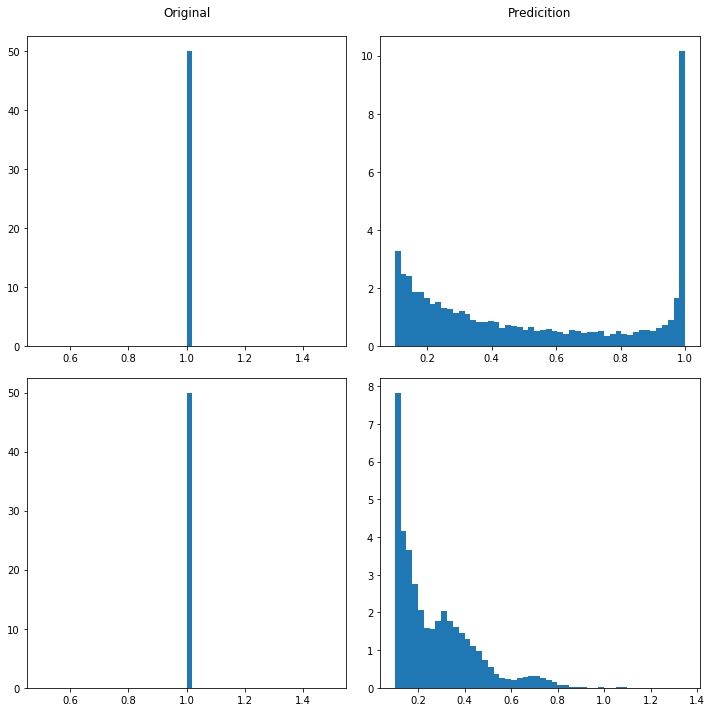

In [14]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'Ppi']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    if i == 1:
        pred_data = predict_DFMF.flatten()
        
    org_data = org_data[org_data > 0]
    pred_data = pred_data[pred_data > 0.1]
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=1)

#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=1)
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'ann_data_distribution_nn_vs_dfmf.png')
plt.show()

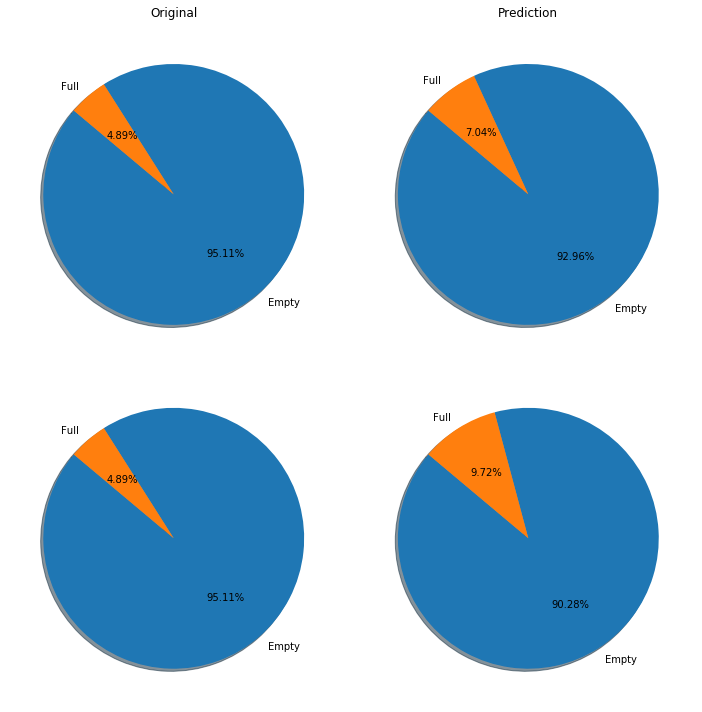

In [15]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    length = len(org_data)
    
    if i == 1:
        pred_data = predict_DFMF.flatten()
    
    org_data_zeros = org_data[org_data == 0]
    org_data_nonzeros = org_data[org_data > 0]
    
    pred_data_zeros = pred_data[pred_data < 0.1]
    pred_data_nonzeros = pred_data[pred_data >= 0.1]
    
    ax = axes[i][0]
    ax.pie([len(org_data_zeros), len(org_data_nonzeros)], labels=labels, autopct='%1.2f%%', shadow=True, startangle=140)
#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    if i == 0:
        ax.set_title(cols[0],pad=15)
    
    
    ax = axes[i][1]
    ax.pie([len(pred_data_zeros), len(pred_data_nonzeros)], labels=labels, autopct='%1.2f%%', shadow=True, startangle=140)
    
    if i == 0:
        ax.set_title(cols[1],pad=15)
        
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + 'ann_pie_chart_zoom_01_nn_vs_dfmf.png')
plt.show()